In [57]:
import os
import sys
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.cluster import KMeans
from torch.utils.data import Subset

warnings.filterwarnings("ignore")


from analysis_utils import *

sys.path.append("../")

from get_mappings import ComputeContributions
from model_all_analysis import HNeRV
from vps_datasets import CityscapesVPSVideoDataSet, VIPSegVideoDataSet

from cluster_utils.cluster_utils import get_gabor_label_map

In [ ]:
dataset_names = ["cityscapes", "vipseg"]
vidnames = {
    "cityscapes": ["0005"],
    "vipseg": ["26_cblDl5vCZnw"],
}


args_dict = {}
dataloader_dict = {}
weights_dict = {}
models_dict = {}
categories_dicts = {}

for dataset_name in dataset_names:
    weights_dict[dataset_name] = {}
    args_dict[dataset_name] = {}
    dataloader_dict[dataset_name] = {}
    models_dict[dataset_name] = {}
    categories_dicts[dataset_name] = {}

    for vidname in vidnames[dataset_name]:
        weights_dict[dataset_name][vidname] = "path/to/checkpoint/"

        args = load_model_args()

        args.weight = os.path.join(
            weights_dict[dataset_name][vidname], f"model_best.pth"
        )
        args.crop_list = "-1" if dataset_name == "cityscapes" else "640_1280"

        model = HNeRV(args)
        model = load_model_checkpoint(model, args)
        models_dict[dataset_name][vidname] = model

        args, categories_dicts[dataset_name][vidname] = load_dataset_specific_args(
            args, dataset_name, vidname
        )

        args_dict[dataset_name][vidname] = args

In [61]:
for dataset_name in dataset_names:
    for vidname in vidnames[dataset_name]:

        args = args_dict[dataset_name][vidname]

        if dataset_name == "cityscapes":
            full_dataset = CityscapesVPSVideoDataSet(args)
        else:
            full_dataset = VIPSegVideoDataSet(args)

        sampler = (
            torch.utils.data.distributed.DistributedSampler(full_dataset)
            if args.distributed
            else None
        )

        args.final_size = full_dataset.final_size
        args.full_data_length = len(full_dataset)
        split_num_list = [int(x) for x in args.data_split.split("_")]
        train_ind_list, args.val_ind_list = data_split(
            list(range(args.full_data_length)), split_num_list, args.shuffle_data, 0
        )

        train_dataset = Subset(full_dataset, train_ind_list)
        train_sampler = (
            torch.utils.data.distributed.DistributedSampler(train_dataset)
            if args.distributed
            else None
        )

        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=args.batchSize,
            shuffle=False,
            num_workers=args.workers,
            pin_memory=True,
            sampler=train_sampler,
            drop_last=True,
            worker_init_fn=worker_init_fn,
        )

        dataloader_dict[dataset_name][vidname] = train_dataloader

In [62]:
def get_instance_info_for_video(inference_results, object_categories, categories):
    instance_to_ann_id_maps = {}

    inst_id_to_cat_and_inst_suffix = {}

    object_to_instances_map = {}
    obj_to_obj_name_idx = {}

    instance_names = []
    object_to_instances_map = defaultdict(list)

    for idx, object_cat in enumerate(object_categories):
        obj_to_obj_name_idx[object_cat] = idx

    for img_idx in inference_results.keys():
        instance_to_ann_id_maps[img_idx] = {}

        frame_annos = inference_results[img_idx]["annotations"]
        for ann in frame_annos:
            category_name = [
                cat["name"] for cat in categories if cat["id"] == ann["category_id"]
            ][0]

            num_instances_of_obj = len(object_to_instances_map[category_name])

            if ann["inst_id"] not in list(inst_id_to_cat_and_inst_suffix.keys()):
                inst_id_to_cat_and_inst_suffix[ann["inst_id"]] = {
                    "category": category_name,
                    "inst_suffix": num_instances_of_obj,  # 0
                    "instance_name": category_name + "_" + str(num_instances_of_obj),
                }

            instance_name = inst_id_to_cat_and_inst_suffix[ann["inst_id"]]["instance_name"]
            instance_to_ann_id_maps[img_idx][instance_name] = ann["id"]
            
            if instance_name not in instance_names:
                object_to_instances_map[category_name].append(instance_name)
                instance_names.append(instance_name)

    def custom_sort_key(item):
        parts = item.split("_")
        return ("_".join(parts[:-1]), int(parts[-1]))

    instance_names = [item for item in sorted(instance_names, key=custom_sort_key)]
    instance_names.append(instance_names.pop(instance_names.index("other_0")))

    return (
        inst_id_to_cat_and_inst_suffix,
        instance_to_ann_id_maps,
        object_to_instances_map,
        obj_to_obj_name_idx,
        instance_names,
    )

In [63]:
def get_instance_contribs(
    head_layer_output_contrib,
    nerv_blk_3_output_contrib,
    annotations,
    instance_to_ann_id_map,
    instance_names,
):
    total_img_area = head_layer_output_contrib.size(
        -2
    ) * head_layer_output_contrib.size(-1)

    num_head_kernels = (
        head_layer_output_contrib.shape[0] * head_layer_output_contrib.shape[1]
    )
    num_blk_3_kernels = (
        nerv_blk_3_output_contrib.shape[0] * nerv_blk_3_output_contrib.shape[1]
    )
    # Map instance IDs to names
    instances_in_curr_frame = list(instance_to_ann_id_map.keys())
    instances_in_curr_frame = [
        instance_names[i]
        for i in range(len(instance_names))
        if instance_names[i] in instances_in_curr_frame
    ]

    num_instances = len(instances_in_curr_frame)
    instance_areas = torch.zeros(num_instances)

    head_kernel_to_instance_contribs = torch.zeros((num_head_kernels, num_instances))
    blk_3_kernel_to_instance_contribs = torch.zeros((num_blk_3_kernels, num_instances))
    head_instance_contrib_ratio_to_total = torch.zeros(
        (num_head_kernels, len(instances_in_curr_frame))
    )
    blk_3_instance_contrib_ratio_to_total = torch.zeros(
        (num_blk_3_kernels, len(instances_in_curr_frame))
    )
    total_head_layer_output_contrib = torch.sum(
        torch.abs(head_layer_output_contrib), dim=(2, 3)
    )
    total_blk_3_output_contrib = torch.sum(
        torch.abs(nerv_blk_3_output_contrib), dim=(2, 3)
    )

    for instance in instances_in_curr_frame:
        ann_id = instance_to_ann_id_map[instance]
        ann = [ann for ann in annotations if ann["id"] == ann_id][0]

        area = ann["area"]
        bimask = ann["bimask"].squeeze()
        
        instance_head_contribs = torch.abs(
            head_layer_output_contrib[:, :, bimask]
        )
        instance_blk_3_contribs = torch.abs(
            nerv_blk_3_output_contrib[:, :, bimask]
        )

        # Get aggregated total contribution for each kernel to the instance
        total_head_contrib = torch.sum(instance_head_contribs, dim=-1)
        total_blk_3_contrib = torch.sum(instance_blk_3_contribs, dim=-1)
        avg_head_contrib = total_head_contrib / area
        avg_blk_3_contrib = total_blk_3_contrib / area

        inst_idx = instances_in_curr_frame.index(instance)

        head_kernel_to_instance_contribs[:, inst_idx] = avg_head_contrib.flatten()
        blk_3_kernel_to_instance_contribs[:, inst_idx] = avg_blk_3_contrib.flatten()

        head_expected_instance_contrib = total_head_layer_output_contrib.flatten(0, 1) * (area / total_img_area)
        head_true_instance_contrib = total_head_contrib.flatten(0, 1)
        head_instance_contrib_ratio_to_total[:, inst_idx] = (
            torch.abs(head_true_instance_contrib - head_expected_instance_contrib)
            / head_expected_instance_contrib
        )
        blk_3_expected_instance_contrib = total_blk_3_output_contrib.flatten(0, 1) * (area / total_img_area)
        blk_3_true_instance_contrib = total_blk_3_contrib.flatten(0, 1)
        blk_3_instance_contrib_ratio_to_total[:, inst_idx] = (
            torch.abs(blk_3_true_instance_contrib - blk_3_expected_instance_contrib)
            / blk_3_expected_instance_contrib
        )

        instance_areas[inst_idx] = area

    return (
        head_kernel_to_instance_contribs,
        blk_3_kernel_to_instance_contribs,
        head_instance_contrib_ratio_to_total,
        blk_3_instance_contrib_ratio_to_total,
        instance_areas,
    )

In [64]:
def get_gridcell_contribs(
    head_layer_output_contrib, nerv_blk_3_output_contrib, reg_stride_h, reg_stride_w
):
    total_img_area = head_layer_output_contrib.size(-2) * head_layer_output_contrib.size(-1)

    head_layer_output_contrib = torch.flatten(
        head_layer_output_contrib, 0, 1
    )  # num_kernels x h x w
    nerv_blk_3_output_contrib = torch.flatten(nerv_blk_3_output_contrib, 0, 1)

    unfolded_head_kernel_to_gridcell_contribs = (
        torch.abs(head_layer_output_contrib)
        .unfold(1, reg_stride_h, reg_stride_h)
        .unfold(2, reg_stride_w, reg_stride_w)
        .permute(0, 3, 4, 1, 2)
    ) # e.g. num_kernels x 4 x 4 x h/4 x w/4
    unfolded_blk_3_kernel_to_gridcell_contribs = (
        torch.abs(nerv_blk_3_output_contrib)
        .unfold(1, reg_stride_h, reg_stride_h)
        .unfold(2, reg_stride_w, reg_stride_w)
        .permute(0, 3, 4, 1, 2)
    )

    total_head_layer_output_contrib = torch.sum(
        torch.abs(head_layer_output_contrib), dim=(1, 2)
    )
    total_blk_3_output_contrib = torch.sum(
        torch.abs(nerv_blk_3_output_contrib), dim=(1, 2)
    )

    head_kernel_to_gridcell_contribs = torch.abs(
        unfolded_head_kernel_to_gridcell_contribs
    )
    blk_3_kernel_to_gridcell_contribs = torch.abs(
        unfolded_blk_3_kernel_to_gridcell_contribs
    )

    # Flatten contributions by region before taking variance over pixels in region
    flattened_head_gridcell_contribs = head_kernel_to_gridcell_contribs.flatten(3, 4)
    flattened_head_gridcell_contribs = flattened_head_gridcell_contribs.flatten(1, 2)
    flattened_blk_3_gridcell_contribs = blk_3_kernel_to_gridcell_contribs.flatten(3, 4)
    flattened_blk_3_gridcell_contribs = flattened_blk_3_gridcell_contribs.flatten(1, 2)

    # Compute deltas: ( actual contrib - expected contrib ) / expected contrib
    gridcell_area = unfolded_head_kernel_to_gridcell_contribs.size(3) * unfolded_head_kernel_to_gridcell_contribs.size(4)
    head_expected_region_contrib = total_head_layer_output_contrib[:, None] * (
        gridcell_area / total_img_area
    )
    head_true_region_contrib = torch.sum(flattened_head_gridcell_contribs, dim=-1)
    head_gridcell_contrib_ratio_to_total = (
        head_true_region_contrib - head_expected_region_contrib
    ) / head_expected_region_contrib
    blk_3_expected_instance_contrib = total_blk_3_output_contrib[:, None] * (
        gridcell_area / total_img_area
    )
    blk_3_true_instance_contrib = torch.sum(flattened_blk_3_gridcell_contribs, dim=-1)
    blk_3_gridcell_contrib_ratio_to_total = (
        blk_3_true_instance_contrib - blk_3_expected_instance_contrib
    ) / blk_3_expected_instance_contrib

    # Aggregate the maps and take per-pixel average
    head_kernel_to_gridcell_contribs = (
        head_kernel_to_gridcell_contribs.sum(dim=(3, 4)) / gridcell_area
    )
    blk_3_kernel_to_gridcell_contribs = (
        blk_3_kernel_to_gridcell_contribs.sum(dim=(3, 4)) / gridcell_area
    )

    head_layer_feature_vectors = head_kernel_to_gridcell_contribs.view(
        head_kernel_to_gridcell_contribs.size(0), -1
    )  # num_head_kernels x num_gridcells
    nerv_blk_3_feature_vectors = blk_3_kernel_to_gridcell_contribs.view(
        blk_3_kernel_to_gridcell_contribs.size(0), -1
    )  # num_blk_3_kernels x num_gridcells

    return (
        head_layer_feature_vectors,
        nerv_blk_3_feature_vectors,
        head_gridcell_contrib_ratio_to_total,
        blk_3_gridcell_contrib_ratio_to_total,
    )

In [ ]:
def compute_kmeans_clusters_in_rgb(image, num_clusters):
    # Reshape to 2D array of num_pixels x 3 (for rgb)
    image_reshaped_rgb = image.reshape(-1, 3)

    kmeans = KMeans(n_clusters=num_clusters, n_init=1, random_state=0).fit(image_reshaped_rgb)
    rgb_cluster_map = kmeans.labels_.reshape(image.shape[0], image.shape[1])

    return rgb_cluster_map

In [65]:
def get_rgb_cluster_contribs(
    head_layer_output_contrib, nerv_blk_3_output_contrib, rgb_cluster_map
):
    total_img_area = head_layer_output_contrib.size(-2) * head_layer_output_contrib.size(-1)

    n_rgb_clusters = len(np.unique(rgb_cluster_map))
    rgb_cluster_areas = torch.zeros(n_rgb_clusters)
    
    num_head_kernels = (
        head_layer_output_contrib.shape[0] * head_layer_output_contrib.shape[1]
    )
    num_blk_3_kernels = (
        nerv_blk_3_output_contrib.shape[0] * nerv_blk_3_output_contrib.shape[1]
    )

    head_kernel_to_rgb_cluster_contribs = torch.zeros(
        (num_head_kernels, n_rgb_clusters)
    )
    blk_3_kernel_to_rgb_cluster_contribs = torch.zeros(
        (num_blk_3_kernels, n_rgb_clusters)
    )
    head_rgb_cluster_contrib_ratio_to_total = torch.zeros(
        (num_head_kernels, n_rgb_clusters)
    )
    blk_3_rgb_cluster_contrib_ratio_to_total = torch.zeros(
        (num_blk_3_kernels, n_rgb_clusters)
    )
    # Store the total kernel-wise contributions to output image
    total_head_layer_output_contrib = torch.sum(
        torch.abs(head_layer_output_contrib), dim=(2, 3)
    )
    total_blk_3_output_contrib = torch.sum(
        torch.abs(nerv_blk_3_output_contrib), dim=(2, 3)
    )

    for cluster_id in np.unique(rgb_cluster_map):

        bimask = rgb_cluster_map == cluster_id
        bimask = bimask.squeeze().astype(bool)
        area = bimask.sum()
        
        rgb_cluster_head_contribs = torch.abs(
            head_layer_output_contrib[:, :, bimask]
        )
        rgb_cluster_blk_3_contribs = torch.abs(
            nerv_blk_3_output_contrib[:, :, bimask]
        )

        # Get aggregated total contribution for each kernel to the instance
        total_head_contrib = torch.sum(rgb_cluster_head_contribs, dim=-1)
        avg_head_contrib = total_head_contrib / area
        total_blk_3_contrib = torch.sum(rgb_cluster_blk_3_contribs, dim=-1)
        avg_blk_3_contrib = total_blk_3_contrib / area

        head_expected_rgb_cluster_contrib = total_head_layer_output_contrib.flatten(0, 1) * (area / total_img_area)
        head_true_rgb_cluster_contrib = total_head_contrib.flatten(0, 1)
        head_rgb_cluster_contrib_ratio_to_total[:, cluster_id] = (
            torch.abs(head_true_rgb_cluster_contrib - head_expected_rgb_cluster_contrib) / head_expected_rgb_cluster_contrib
        )

        blk_3_expected_rgb_cluster_contrib = total_blk_3_output_contrib.flatten(0, 1) * (area / total_img_area)
        blk_3_true_rgb_cluster_contrib = total_blk_3_contrib.flatten(0, 1)
        blk_3_rgb_cluster_contrib_ratio_to_total[:, cluster_id] = (
            torch.abs(blk_3_true_rgb_cluster_contrib - blk_3_expected_rgb_cluster_contrib) / blk_3_expected_rgb_cluster_contrib
        )

        rgb_cluster_areas[cluster_id] = area
        head_kernel_to_rgb_cluster_contribs[:, cluster_id] = avg_head_contrib.flatten()
        blk_3_kernel_to_rgb_cluster_contribs[:, cluster_id] = (avg_blk_3_contrib.flatten())

    return (
        head_kernel_to_rgb_cluster_contribs,
        blk_3_kernel_to_rgb_cluster_contribs,
        head_rgb_cluster_contrib_ratio_to_total,
        blk_3_rgb_cluster_contrib_ratio_to_total,
        rgb_cluster_areas,
    )

In [68]:
def get_gabor_cluster_contribs(
    head_layer_output_contrib, nerv_blk_3_output_contrib, gabor_cluster_map
):
    total_img_area = head_layer_output_contrib.size(-2) * head_layer_output_contrib.size(-1)

    n_gabor_clusters = len(np.unique(gabor_cluster_map))
    num_head_kernels = (
        head_layer_output_contrib.shape[0] * head_layer_output_contrib.shape[1]
    )
    num_blk_3_kernels = (
        nerv_blk_3_output_contrib.shape[0] * nerv_blk_3_output_contrib.shape[1]
    )

    gabor_cluster_areas = torch.zeros(n_gabor_clusters)

    head_kernel_to_gabor_cluster_contribs = torch.zeros(
        (num_head_kernels, n_gabor_clusters)
    )
    blk_3_kernel_to_gabor_cluster_contribs = torch.zeros(
        (num_blk_3_kernels, n_gabor_clusters)
    )
    head_gabor_cluster_contrib_ratio_to_total = torch.zeros(
        (num_head_kernels, n_gabor_clusters)
    )
    blk_3_gabor_cluster_contrib_ratio_to_total = torch.zeros(
        (num_blk_3_kernels, n_gabor_clusters)
    )
    total_head_layer_output_contrib = torch.sum(
        torch.abs(head_layer_output_contrib), dim=(2, 3)
    )
    total_blk_3_output_contrib = torch.sum(
        torch.abs(nerv_blk_3_output_contrib), dim=(2, 3)
    )

    for cluster_id in np.unique(gabor_cluster_map):

        bimask = gabor_cluster_map == cluster_id
        bimask = bimask.squeeze().astype(bool)
        area = bimask.sum()

        gabor_cluster_head_contribs = torch.abs(
            head_layer_output_contrib[:, :, bimask]
        )
        gabor_cluster_blk_3_contribs = torch.abs(
            nerv_blk_3_output_contrib[:, :, bimask]
        )

        # Get aggregated total contribution for each kernel to the instance
        total_head_contrib = torch.sum(gabor_cluster_head_contribs, dim=-1)
        avg_head_contrib = total_head_contrib / area
        total_blk_3_contrib = torch.sum(gabor_cluster_blk_3_contribs, dim=-1)
        avg_blk_3_contrib = total_blk_3_contrib / area

        # Store percentage of each superpixel's contribution to total contribution to image
        head_expected_gabor_cluster_contrib = total_head_layer_output_contrib.flatten(0, 1) * (area / total_img_area)
        head_true_gabor_cluster_contrib = total_head_contrib.flatten(0, 1)
        head_gabor_cluster_contrib_ratio_to_total[:, cluster_id] = (
            torch.abs(head_true_gabor_cluster_contrib - head_expected_gabor_cluster_contrib) / head_expected_gabor_cluster_contrib
        )

        blk_3_expected_gabor_cluster_contrib = total_blk_3_output_contrib.flatten(
            0, 1
        ) * (area / total_img_area)
        blk_3_true_gabor_cluster_contrib = total_blk_3_contrib.flatten(0, 1)
        blk_3_gabor_cluster_contrib_ratio_to_total[:, cluster_id] = (
            torch.abs(blk_3_true_gabor_cluster_contrib - blk_3_expected_gabor_cluster_contrib) / blk_3_expected_gabor_cluster_contrib
        )

        gabor_cluster_areas[cluster_id] = area
        head_kernel_to_gabor_cluster_contribs[:, cluster_id] = (
            avg_head_contrib.flatten()
        )
        blk_3_kernel_to_gabor_cluster_contribs[:, cluster_id] = (
            avg_blk_3_contrib.flatten()
        )

    return (
        head_kernel_to_gabor_cluster_contribs,
        blk_3_kernel_to_gabor_cluster_contribs,
        head_gabor_cluster_contrib_ratio_to_total,
        blk_3_gabor_cluster_contrib_ratio_to_total,
        gabor_cluster_areas,
    )

In [69]:
def compute_inference_results(
    dataset_name,
    train_dataloader,
    model,
    categories_dict,
    args,
    num_rgb_clusters,
    num_gabor_clusters,
):
    if dataset_name == "vipseg":
        # Sample few frames
        num_indices = len(train_dataloader) * args.b
        num_samples = 6
        sampled_img_indices = [
            i * (num_indices - 1) // (num_samples - 1) for i in range(num_samples)
        ]

    categories_in_video = {}
    inference_results = {}

    with torch.no_grad():
        for batch in train_dataloader:
            img_data, norm_idx, img_idx = (
                batch["img"].to("cuda"),
                batch["norm_idx"].to("cuda"),
                batch["idx"].to("cuda"),
            )
            annotations = batch["annotations"]

            if dataset_name == "vipseg" and (img_idx not in sampled_img_indices):
                continue

            if len(annotations) > 0:
                annotations = convert_annotations_to_numpy(annotations)
                # Filter annotations to remove non-persistent instances
                annotations = add_other_annotation(annotations)

                images = batch["img"].cuda()
                (
                    _,
                    _,
                    _,
                    decoder_results,
                    img_out,
                ) = model(norm_idx)

                image_numpy = images[0].permute(1, 2, 0).cpu().numpy()
                rgb_cluster_map = compute_kmeans_clusters_in_rgb(
                    image_numpy, num_rgb_clusters
                )
                # Compute Gabor clusters map
                image_pil_format = (
                    (images[0].clamp(0, 1) * 255)
                    .permute(1, 2, 0)
                    .cpu()
                    .numpy()
                    .astype(np.uint8)
                )
                gabor_cluster_map = get_gabor_label_map(
                    image_pil_format, num_gabor_clusters
                )

                inference_results[img_idx.item()] = {
                    "decoder_results": decoder_results,
                    "img_out": img_out,
                    "annotations": annotations,
                    "rgb_cluster_map": rgb_cluster_map,
                    "gabor_cluster_map": gabor_cluster_map,
                }

                for ann in annotations:
                    if ann["category_id"] not in categories_in_video:
                        categories_in_video[ann["category_id"]] = categories_dict[
                            ann["category_id"]
                        ]

    # Add "other" category
    categories_in_video[-1] = categories_dict[-1]
    object_categories = [v["name"] for k, v in categories_in_video.items()]
    categories_in_video = [v for k, v in categories_in_video.items()]

    return inference_results, categories_in_video, object_categories

In [70]:
def compute_all_variables_for_video(
    model,
    args,
    inference_results,
    instance_to_ann_id_maps,
    cell_stride_h,
    cell_stride_w,
    instance_names,
    inst_id_to_cat_and_inst_suffix,
    num_rgb_clusters,
    num_gabor_clusters,
):

    all_variables_for_video = {}
    num_regions = cell_stride_h * cell_stride_w

    for img_idx, value in inference_results.items():
        img_out = value["img_out"]
        decoder_results = value["decoder_results"]
        annotations = value["annotations"]
        rgb_cluster_map = value["rgb_cluster_map"]
        gabor_cluster_map = value["gabor_cluster_map"]

        instance_to_ann_id_map = instance_to_ann_id_maps[img_idx]

        compute_contrib_obj = ComputeContributions(
            model, args, decoder_results, img_out.detach().clone()[0]
        )

        # The following can be extended to inner blocks of NeRV as well
        head_layer_output_contrib = compute_contrib_obj.compute_head_mappings()
        nerv_blk_3_output_contrib, _ = (
            compute_contrib_obj.compute_last_nerv_block_mappings()
        )
        # Get contributions clustered by each entity type and normalize them.
        # Additionally, obtain variances within instance.
        (
            head_kernel_to_instance_contribs,
            blk_3_kernel_to_instance_contribs,
            head_instance_contrib_ratio_to_total,
            blk_3_instance_contrib_ratio_to_total,
            instance_areas,
        ) = get_instance_contribs(
            head_layer_output_contrib,
            nerv_blk_3_output_contrib,
            annotations,
            instance_to_ann_id_map,
            instance_names,
            inst_id_to_cat_and_inst_suffix,
        )
        (
            head_kernel_to_gridcell_contribs,
            blk_3_kernel_to_gridcell_contribs,
            head_gridcell_contrib_ratio_to_total,
            blk_3_gridcell_contrib_ratio_to_total,
        ) = get_gridcell_contribs(
            head_layer_output_contrib,
            nerv_blk_3_output_contrib,
            cell_stride_h,
            cell_stride_w,
        )
        (
            head_kernel_to_rgb_cluster_contribs,
            blk_3_kernel_to_rgb_cluster_contribs,
            head_rgb_cluster_contrib_ratio_to_total,
            blk_3_rgb_cluster_contrib_ratio_to_total,
            rgb_cluster_areas,
        ) = get_rgb_cluster_contribs(
            head_layer_output_contrib, nerv_blk_3_output_contrib, rgb_cluster_map
        )
        (
            head_kernel_to_gabor_cluster_contribs,
            blk_3_kernel_to_gabor_cluster_contribs,
            head_gabor_cluster_contrib_ratio_to_total,
            blk_3_gabor_cluster_contrib_ratio_to_total,
            gabor_cluster_areas,
        ) = get_gabor_cluster_contribs(
            head_layer_output_contrib, nerv_blk_3_output_contrib, gabor_cluster_map
        )

        all_variables_for_video[img_idx] = {
            "head_layer_output_contrib": torch.abs(head_layer_output_contrib),
            "nerv_blk_3_output_contrib": torch.abs(nerv_blk_3_output_contrib),
            # head contribs
            "head_kernel_to_instance_contribs": head_kernel_to_instance_contribs,
            "head_kernel_to_gridcell_contribs": head_kernel_to_gridcell_contribs,
            "head_kernel_to_rgb_cluster_contribs": head_kernel_to_rgb_cluster_contribs,
            "head_kernel_to_gabor_cluster_contribs": head_kernel_to_gabor_cluster_contribs,
            # blk_3 contribs
            "blk_3_kernel_to_instance_contribs": blk_3_kernel_to_instance_contribs,
            "blk_3_kernel_to_gridcell_contribs": blk_3_kernel_to_gridcell_contribs,
            "blk_3_kernel_to_rgb_cluster_contribs": blk_3_kernel_to_rgb_cluster_contribs,
            "blk_3_kernel_to_gabor_cluster_contribs": blk_3_kernel_to_gabor_cluster_contribs,
            # areas
            "instance_areas": instance_areas,
            "rgb_cluster_areas": rgb_cluster_areas,
            "gabor_cluster_areas": gabor_cluster_areas,
            "num_instances_in_frame": len(instance_areas),
            "cell_stride_h": cell_stride_h,
            "cell_stride_w": cell_stride_w,
            "num_rgb_clusters": num_rgb_clusters,
            "num_gabor_clusters": num_gabor_clusters,
            # per-patch contribution ratios
            "head_instance_contrib_ratio_to_total": head_instance_contrib_ratio_to_total,
            "blk_3_instance_contrib_ratio_to_total": blk_3_instance_contrib_ratio_to_total,
            "head_gridcell_contrib_ratio_to_total": head_gridcell_contrib_ratio_to_total,
            "blk_3_gridcell_contrib_ratio_to_total": blk_3_gridcell_contrib_ratio_to_total,
            "head_rgb_cluster_contrib_ratio_to_total": head_rgb_cluster_contrib_ratio_to_total,
            "blk_3_rgb_cluster_contrib_ratio_to_total": blk_3_rgb_cluster_contrib_ratio_to_total,
            "head_gabor_cluster_contrib_ratio_to_total": head_gabor_cluster_contrib_ratio_to_total,
            "blk_3_gabor_cluster_contrib_ratio_to_total": blk_3_gabor_cluster_contrib_ratio_to_total,
        }

    return all_variables_for_video

In [75]:
def compute_variance_of_deltas(all_variables_for_video):

    # Take variance of deltas (between expected and actual patch contrib)
    img_idx = 0
    all_vars_for_first_frame = all_variables_for_video[img_idx]

    fig, axs = plt.subplots(1, 2, tight_layout=True)

    # Variance per neuron is taken over all H*W pixels in its contribution map
    # If any variances are nan, then the neuron does not contribute to any pixel in the image - it is dead.
    head_instance_variances = torch.var(
        all_vars_for_first_frame["head_instance_contrib_ratio_to_total"], dim=-1
    )
    head_gridcell_variances = torch.var(
        all_vars_for_first_frame["head_gridcell_contrib_ratio_to_total"], dim=-1
    )
    head_rgb_cluster_variances = torch.var(
        all_vars_for_first_frame["head_rgb_cluster_contrib_ratio_to_total"], dim=-1
    )
    head_gabor_cluster_variances = torch.var(
        all_vars_for_first_frame["head_gabor_cluster_contrib_ratio_to_total"], dim=-1
    )

    blk_3_instance_variances = torch.var(
        all_vars_for_first_frame["blk_3_instance_contrib_ratio_to_total"], dim=-1
    )
    blk_3_gridcell_variances = torch.var(
        all_vars_for_first_frame["blk_3_gridcell_contrib_ratio_to_total"], dim=-1
    )
    blk_3_rgb_cluster_variances = torch.var(
        all_vars_for_first_frame["blk_3_rgb_cluster_contrib_ratio_to_total"], dim=-1
    )
    blk_3_gabor_cluster_variances = torch.var(
        all_vars_for_first_frame["blk_3_gabor_cluster_contrib_ratio_to_total"], dim=-1
    )

    sorted_variance_head_instance_contrib_ratio, head_instance_sorted_indices = (
        torch.sort(head_instance_variances)
    )
    sorted_variance_head_gridcell_contrib_ratio, head_gridcell_sorted_indices = (
        torch.sort(head_gridcell_variances)
    )
    sorted_variance_head_rgb_cluster_contrib_ratio, head_rgb_sorted_indices = (
        torch.sort(head_rgb_cluster_variances)
    )
    sorted_variance_head_gabor_cluster_contrib_ratio, head_gabor_sorted_indices = (
        torch.sort(head_gabor_cluster_variances)
    )

    sorted_variance_blk_3_instance_contrib_ratio, blk_3_instance_sorted_indices = (
        torch.sort(blk_3_instance_variances)
    )
    sorted_variance_blk_3_gridcell_contrib_ratio, blk_3_gridcell_sorted_indices = (
        torch.sort(blk_3_gridcell_variances)
    )
    sorted_variance_blk_3_rgb_cluster_contrib_ratio, blk_3_rgb_sorted_indices = (
        torch.sort(blk_3_rgb_cluster_variances)
    )
    sorted_variance_blk_3_gabor_cluster_contrib_ratio, blk_3_gabor_sorted_indices = (
        torch.sort(blk_3_gabor_cluster_variances)
    )

    # Drop NaNs (remove dead neurons)
    axs[0].plot(sorted_variance_head_instance_contrib_ratio, label="Instances variance", c="r")
    axs[0].plot(sorted_variance_head_gridcell_contrib_ratio, label="Grid cells variance", c="g")
    axs[0].plot(sorted_variance_head_rgb_cluster_contrib_ratio, label="RGB Cluster variance", c="b")
    axs[0].plot(sorted_variance_head_gabor_cluster_contrib_ratio, label="Gabor Cluster variance", c="m")
    axs[0].set_title(f"Head Layer")

    axs[1].plot(sorted_variance_blk_3_instance_contrib_ratio, label="Instances variance", c="r")
    axs[1].plot(sorted_variance_blk_3_gridcell_contrib_ratio, label="Grid cells variance", c="g")
    axs[1].plot(sorted_variance_blk_3_rgb_cluster_contrib_ratio, label="RGB Cluster variance", c="b")
    axs[1].plot(sorted_variance_blk_3_gabor_cluster_contrib_ratio, label="Gabor Cluster variance", c="m")
    axs[1].set_title(f"NeRV Block 3")

    sorted_deltas_dict = {
        "head": {
            "instances_deltas": sorted_variance_head_instance_contrib_ratio,
            "gridcells_deltas": sorted_variance_head_gridcell_contrib_ratio,
            "rgb_clusters_deltas": sorted_variance_head_rgb_cluster_contrib_ratio,
            "gabor_clusters_deltas": sorted_variance_head_gabor_cluster_contrib_ratio,
        },
        "blk_3": {
            "instances_deltas": sorted_variance_blk_3_instance_contrib_ratio,
            "gridcells_deltas": sorted_variance_blk_3_gridcell_contrib_ratio,
            "rgb_clusters_deltas": sorted_variance_blk_3_rgb_cluster_contrib_ratio,
            "gabor_clusters_deltas": sorted_variance_blk_3_gabor_cluster_contrib_ratio,
        },
        "sorted_indices": {
            "head": {
                "instances": head_instance_sorted_indices,
                "gridcells": head_gridcell_sorted_indices,
                "rgb_clusters": head_rgb_sorted_indices,
                "gabor_clusters": head_gabor_sorted_indices,
            },
            "blk_3": {
                "instances": blk_3_instance_sorted_indices,
                "gridcells": blk_3_gridcell_sorted_indices,
                "rgb_clusters": blk_3_rgb_sorted_indices,
                "gabor_clusters": blk_3_gabor_sorted_indices,
            },
        },
    }

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=6, bbox_to_anchor=(0.5, 1.05))

    return sorted_deltas_dict

Analyze each video and save the raw values for downstream visualization

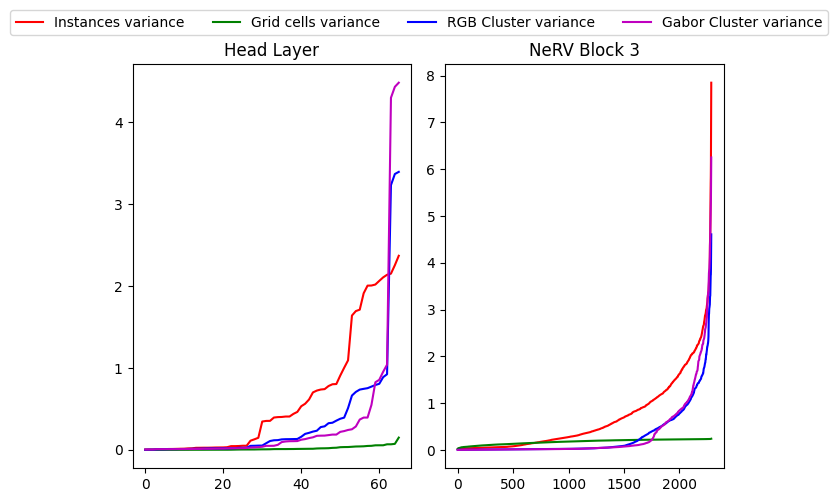

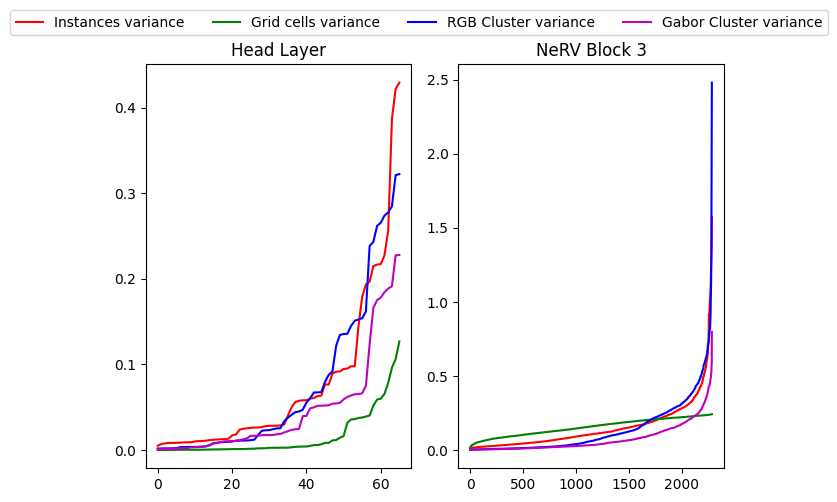

In [76]:
per_vid_patches_deltas_var_dict = {}

# Cluster settings
num_rgb_and_gabor_clusters_dict = {"0005": 32, "26_cblDl5vCZnw": 24}
cell_stride_h_dict = {"0005": 4, "26_cblDl5vCZnw": 4}
cell_stride_w_dict = {"0005": 8, "26_cblDl5vCZnw": 6}


for dataset_name in dataset_names:
    for vidname in vidnames[dataset_name]:
        train_dataloader = dataloader_dict[dataset_name][vidname]
        model = models_dict[dataset_name][vidname]
        args = args_dict[dataset_name][vidname]
        categories_dict = categories_dicts[dataset_name][vidname]

        categories = list(categories_dict.values())

        num_rgb_clusters = num_rgb_and_gabor_clusters_dict[vidname]
        num_gabor_clusters = num_rgb_and_gabor_clusters_dict[vidname]
        cell_stride_h, cell_stride_w = (
            cell_stride_h_dict[vidname],
            cell_stride_w_dict[vidname],
        )

        inference_results, categories_in_video, object_categories = (
            compute_inference_results(
                dataset_name,
                train_dataloader,
                model,
                categories_dict,
                args,
                num_rgb_clusters,
                num_gabor_clusters,
            )
        )

        (
            inst_id_to_cat_and_inst_suffix,
            instance_to_ann_id_maps,
            object_to_instances_map,
            obj_to_obj_name_idx,
            instance_names,
        ) = get_instance_info_for_video(
            inference_results, object_categories, categories
        )

        all_variables_for_video = compute_all_variables_for_video(
            model,
            args,
            inference_results,
            instance_to_ann_id_maps,
            cell_stride_h,
            cell_stride_w,
            instance_names,
            inst_id_to_cat_and_inst_suffix,
            num_rgb_clusters,
            num_gabor_clusters,
        )

        sorted_deltas_dict = compute_variance_of_deltas(all_variables_for_video)

        per_vid_patches_deltas_var_dict[vidname] = {
            "sorted_deltas_dict": sorted_deltas_dict,
            "cluster_info": {
                "num_instances": ["num_instances_in_frame"],
                "num_rgb_clusters": num_rgb_clusters,
                "num_gabor_clusters": num_gabor_clusters,
                "cell_stride_h": cell_stride_h,
                "cell_stride_w": cell_stride_w,
            },
        }

In [80]:
import pickle

save_dir = "../analysis_data/NeRV/objects_and_motion"
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, f"per_vid_patch_deltas_var_dict.pkl"), "wb") as f:
    pickle.dump(per_vid_patches_deltas_var_dict, f)